# Forecasting Wearing-off

References:
* [Machine Learning Mastery's Time Series Tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [Tensorflow's Time Series Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)


# Load libraries

In [1]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import Normalizer

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For visualization
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap.umap_ as umap

# For evaluation
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# For resampling

# Load configuration

In [2]:
# Participant to process
USER = 'participant1'
# USER = f'participant{sys.argv[1]}'

# Collection dataset
# COLLECTION = '2-person'
COLLECTION = '10-person'
# COLLECTION = '3-person'

# Define base path
BASE_DATA_PATH = '/workspaces/data'

# Define results path
RESULTS_PATH = '/workspaces/results'

FIGSIZE = (20, 7)
FIGSIZE_CM = (13, 7)

In [3]:
# Choose features
# Garmin features
features = ['heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem',
            'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# FonLog features
# features += ['time_from_last_drug_taken', 'wo_duration']

# Additional features
# features += ['timestamp_hour', 'timestamp_dayofweek',
features += ['timestamp_dayofweek',
             'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

# Normalize features
normalize_features = features

In [4]:
# Metrics & Other Hyperparameters
SHIFT = 4
RECORD_SIZE_PER_DAY = 96  # 60 minutes / 15 minutes * 24 hours

In [5]:
# Test set periods
test_set_horizons = {
  "participant1": ["2021-12-02 0:00", "2021-12-03 23:45"],
  "participant2": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant3": ["2021-11-25 0:00", "2021-11-26 23:45"],
  "participant4": ["2021-12-06 0:00", "2021-12-07 7:15"],
  "participant5": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant6": ["2021-12-06 0:00", "2021-12-07 23:45"],
  "participant7": ["2021-12-12 0:00", "2021-12-13 9:45"],
  "participant8": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant9": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant10": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant11": ["2023-01-30 0:00", "2023-01-31 23:45"],
  "participant12": ["2023-01-10 0:00", "2023-01-11 23:45"],
  "participant13": ["2023-01-29 0:00", "2023-01-30 23:45"],
}

# Load dataset

In [6]:
# Load participant's Excel file
dataset = pd.read_excel(f'{BASE_DATA_PATH}/{COLLECTION}/combined_data.xlsx',
                        index_col="timestamp",
                        usecols=columns,
                        engine='openpyxl')

# Fill missing data with 0
dataset.fillna(0, inplace=True)

In [7]:
# Load participant's Excel file
dataset2 = pd.read_excel(f'{BASE_DATA_PATH}/3-person/combined_data.xlsx',
                         index_col="timestamp",
                         usecols=columns,
                         engine='openpyxl')

# Fill missing data with 0
dataset2.fillna(0, inplace=True)

# Combine datasets
dataset = pd.concat([dataset, dataset2])

# Visualize dataset

In [8]:
# Set configuration for visualization

# Font size
# xx-large: 17.28
# Reference: https://stackoverflow.com/a/62289322/2303766
plt.rcParams.update({'font.size': '17.28'})

# increase plot fontsize by 20% of default size
# plt.rcParams.update({'font.size': 1.2 * plt.rcParams['font.size']})

# reset fontsize to default
# plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})

########################################
# Garmin features
features_to_visualize = ['heart_rate', 'steps', 'stress_score',
                         'awake', 'deep', 'light', 'rem',
                         'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# FonLog features
# features_to_visualize += ['time_from_last_drug_taken', 'wo_duration']

# Additional features
# features_to_visualize += ['timestamp_hour', 'timestamp_dayofweek',
features_to_visualize += ['timestamp_dayofweek',
                          'timestamp_hour_sin', 'timestamp_hour_cos']

########################################
# Figure size
FIGSIZE_VIZ = (20, 10)

## Wearing-off distribution

In [9]:
%%script false --no-raise-error # Wearing-off Distribution
# normalized value_count per row per participant
imbalance_table = dataset.pivot_table(
  index='participant',
  columns='wearing_off',
  aggfunc='size'
).apply(lambda x: x / x.sum() * 100, axis=1).round(3)

imbalance_table[[1]].plot(kind='hist', figsize=FIGSIZE_VIZ,
                          title='Wearing-off Percentage Distribution')

# add dashed line at the median
plt.axvline(imbalance_table[1].median(), color='k',
            linestyle='dashed', linewidth=1)
# add label to the dashed line
min_ylim, max_ylim = plt.ylim()
plt.text(imbalance_table[1].median() * 0.72, max_ylim * 0.9,
         'Median Wearing-off %: {:.2f}%'.format(imbalance_table[1].median()))

# add dashed line at the mean
plt.axvline(imbalance_table[1].mean(), color='r',
            linestyle='dashed', linewidth=1)
# add label to the dashed line
min_ylim, max_ylim = plt.ylim()
plt.text(imbalance_table[1].mean() * 1.025, max_ylim * 0.8,
         'Mean Wearing-off %: {:.2f}%'.format(imbalance_table[1].mean()),
         color='r')

# add y-axis label
plt.ylabel('Number of Participants')

# add x-axis label
plt.xlabel('Wearing-off %')

# Remvoe legend
plt.legend().remove()

plt.show()

dataset.pivot_table(
  index='participant',
  columns='wearing_off',
  aggfunc='size'
).apply(lambda x: x / x.sum() * 100, axis=1).round(3).sort_values(by=1, ascending=True)

## Time-series of features with wearing-off

In [10]:
%%script false --no-raise-error # Features with wearing-off across time
axes = dataset.loc[:, features_to_visualize].plot(
  subplots=True, figsize=FIGSIZE)
for index, axis in enumerate(axes):
  if index == 0:
    axis.set_title(
      label='Garmin data with wearing-off periods for Participant {}'.format(
        USER.replace("participant", "")
      ),
      fontdict={
        'fontsize': 'xx-large',
        'fontweight': 'bold'
      }
    )

  column = dataset.columns[index]
  min_value = dataset[[column]].min()
  max_value = dataset[[column]].max()

  if min_value.values[0] > 0:
    min_value = 0

  axis.fill_between(
      x=dataset.index, y1=min_value, y2=max_value,
      where=dataset.wearing_off,
      alpha=0.4, color="red", transform=axis.get_xaxis_transform()
  )
  axis.legend([column], loc="lower right", fontsize='xx-large')
  axis.tick_params(axis='both', which='both', labelsize='xx-large')
  axis.set_xlabel(xlabel=dataset.index.name, fontsize='xx-large')

  # Add vertical line at test_horizon[0]
  axis.axvline(x=test_set_horizons[USER][0], color='black', linestyle='--')

plt.show()

## Wearing-off heatmap per day, per hour

In [11]:
%%script false --no-raise-error # Heatmap of wearing-off per day per hour
pivot_table = dataset.pivot_table(index=dataset.index.date,
                                  columns=dataset.index.hour,
                                  values='wearing_off',
                                  aggfunc='sum'
                                  ).fillna(0).astype(int)

# plot heatmap of wearing-off per day per hour, and
#   text color matches the background color
pivot_table.style.background_gradient(
  cmap='Reds', axis=None
).text_gradient(
  cmap='Reds', axis=None
)

# Display pivot_table as figure
plt.figure(figsize=(20, 20))
# Add label to sns's colorbar
sns.heatmap(pivot_table, cmap='Reds', annot=False, fmt='d',
            cbar_kws={'label': 'Count of Wearing-off'})
plt.title('Wearing-off per day per hour')
plt.xlabel('Hour')
plt.ylabel('Day')
plt.show()

## (PCA) Boundary between wearing-off with non-wearing-off

In [12]:
%%script false --no-raise-error # Compress all columns into 2 columns using PCA
pca = PCA(n_components=2, random_state=4)

# Fit PCA
pca.fit(dataset[features_to_visualize])

# Transform dataset
dataset_pca = pca.transform(dataset[features_to_visualize])

# Create dataframe from dataset_pca and dataset.wearing_off
dataset_pca = pd.DataFrame(dataset_pca, columns=['pca1', 'pca2'])
dataset_pca['wearing_off'] = dataset.wearing_off.values

# Plot PCA with line that separates wearing-off (1) and non-wearing-off (0)
plt.figure(figsize=FIGSIZE_VIZ)

plt.scatter(dataset_pca[dataset_pca.wearing_off == 0].pca1,
            dataset_pca[dataset_pca.wearing_off == 0].pca2,
            color='blue', alpha=0.5, label='Non-wearing-off')

plt.scatter(dataset_pca[dataset_pca.wearing_off == 1].pca1,
            dataset_pca[dataset_pca.wearing_off == 1].pca2,
            color='red', alpha=0.5, label='Wearing-off')

plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Wearing-off and Non-wearing-off using PCA (n=2)')

# Add dashed lines at 0,0
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

In [13]:
%%script false --no-raise-error # Compress all columns into 3 columns using PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=4)

# Fit PCA
pca.fit(dataset[features_to_visualize])

# Transform dataset
dataset_pca = pca.transform(dataset[features_to_visualize])

# Create dataframe from dataset_pca and dataset.wearing_off
dataset_pca = pd.DataFrame(dataset_pca, columns=['pca1', 'pca2', 'pca3'])
dataset_pca['wearing_off'] = dataset.wearing_off.values

# Plot PCA with line that separates wearing-off (1) and non-wearing-off (0)
fig = plt.figure(figsize=FIGSIZE_VIZ)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataset_pca[dataset_pca.wearing_off == 0].pca1,
           dataset_pca[dataset_pca.wearing_off == 0].pca2,
           dataset_pca[dataset_pca.wearing_off == 0].pca3,
           color='blue', alpha=0.5, label='Non-wearing-off')

ax.scatter(dataset_pca[dataset_pca.wearing_off == 1].pca1,
           dataset_pca[dataset_pca.wearing_off == 1].pca2,
           dataset_pca[dataset_pca.wearing_off == 1].pca3,
           color='red', alpha=0.5, label='Wearing-off')

ax.legend()
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Wearing-off and Non-wearing-off using PCA (n=3)')

plt.show()

## (t-SNE) Boundary between wearing-off and non-wearing-off using tSNE

In [14]:
%%script false --no-raise-error # Compress all columns into 2 columns using t-SNE
tsne = TSNE(
  metric="euclidean",
  n_jobs=-1,
  random_state=4,
  verbose=True,
)

# Fit t-SNE
dataset_tsne = tsne.fit(dataset[features_to_visualize].values)

# Create dataframe from dataset_tsne and dataset.wearing_off
dataset_tsne = pd.DataFrame(dataset_tsne, columns=['tsne1', 'tsne2'])
dataset_tsne['wearing_off'] = dataset.wearing_off.values

# Plot t-SNE with line that separates wearing-off (1) and non-wearing-off (0)
plt.figure(figsize=FIGSIZE_VIZ)

plt.scatter(dataset_tsne[dataset_tsne.wearing_off == 0].tsne1,
            dataset_tsne[dataset_tsne.wearing_off == 0].tsne2,
            color='blue', alpha=0.5, label='Non-wearing-off')

plt.scatter(dataset_tsne[dataset_tsne.wearing_off == 1].tsne1,
            dataset_tsne[dataset_tsne.wearing_off == 1].tsne2,
            color='red', alpha=0.5, label='Wearing-off')

plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.title('Wearing-off and Non-wearing-off using t-SNE')

# Add dashed lines at 0,0
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

## (UMAP) Boundary between wearing-off and non-wearing-off using UMAP

In [15]:
%%script false --no-raise-error # Compress all columns into 2 columns using UMAP
# Fit UMAP
umap_model = umap.UMAP(n_components=2, random_state=4)
umap_model.fit(dataset[features_to_visualize])

# Transform dataset
dataset_umap = umap_model.transform(dataset[features_to_visualize])
dataset_umap = pd.DataFrame(dataset_umap, columns=['umap1', 'umap2'])
dataset_umap['wearing_off'] = dataset.wearing_off.values

# Plot UMAP with line that separates wearing-off (1) and non-wearing-off (0)
plt.figure(figsize=FIGSIZE_VIZ)

plt.scatter(dataset_umap[dataset_umap.wearing_off == 0].umap1,
            dataset_umap[dataset_umap.wearing_off == 0].umap2,
            color='blue', alpha=0.5, label='Non-wearing-off')

plt.scatter(dataset_umap[dataset_umap.wearing_off == 1].umap1,
            dataset_umap[dataset_umap.wearing_off == 1].umap2,
            color='red', alpha=0.5, label='Wearing-off')

plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.title('Wearing-off and Non-wearing-off using UMAP')

# Add dashed lines at 0,0
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

# Prepare dataset

## Split dataset into train and test sets

In [16]:
# Keep a copy of the original dataset
original_dataset = dataset.copy()

In [17]:
USER = 'participant1'
sampling_rates = [0.5, 0.4, 0.3, 0.2, 0.1]
sampling_rate = sampling_rates[2]

In [18]:
# Filter by participant
dataset = original_dataset.query(f'participant == "{USER}"').drop(
    columns=['participant']).copy()

In [19]:
train_df = dataset.loc[
  dataset.index < test_set_horizons[USER][0]
].copy()
test_df = dataset.loc[test_set_horizons[USER][0]:].copy()

# # Divide train_df to train_df and validation_df where validation_df is the last 20% of train_df
# validation_df = train_df.iloc[int(len(train_df) * 0.8):].copy()
# train_df = train_df.iloc[:int(len(train_df) * 0.8)].copy()

In [20]:
%%script false --no-raise-error # OVERRIDE
train_df = dataset.copy()
test_df = dataset.copy()

### Visualize train & test sets

In [21]:
%%script false --no-raise-error # Visualize train and test split for each participant

for user in test_set_horizons.keys():
  # Filter by participant
  dataset = original_dataset.query(f'participant == "{user}"').drop(
      columns=['participant']).copy()

  ################################
  train_df = dataset.loc[
    dataset.index < test_set_horizons[user][0]
  ].copy()
  test_df = dataset.loc[test_set_horizons[user][0]:].copy()

  # Plot wearing-off periods from train and test set within 2, 1 subplot
  fig, axes = plt.subplots(2, 1, figsize=FIGSIZE_VIZ)

  # Plot train wearing-off periods
  axes[0].plot(train_df.wearing_off,
               label='train set', color='blue',)  # marker='o',)

  # Dashed horizontal line at 0.5
  axes[0].axhline(0.5, linestyle='--', color='gray')

  # Dashed vertical lines on each start of the day
  for i in train_df.index:
    if pd.Timestamp(i).hour == 0 and pd.Timestamp(i).minute == 0:
      axes[0].axvline(i, linestyle='--', color='gray')

  # Set x and y labels
  # axes[0].set_xlabel('Time')
  # axes[0].set_ylabel('Wearing-off Forecast Probability')

  # Set title
  axes[0].set_title(
    f'Wearing-off Periods for {user.upper()} (Train set with {round(len(train_df) / RECORD_SIZE_PER_DAY, 1)} days))')

  ################################
  # Plot test wearing-off periods
  axes[1].plot(test_df.wearing_off,
               label='test set', color='blue',)  # marker='o',)

  # Dashed horizontal line at 0.5
  axes[1].axhline(0.5, linestyle='--', color='gray')

  # Dashed vertical lines on each start of the day
  for i in test_df.index:
    if pd.Timestamp(i).hour == 0 and pd.Timestamp(i).minute == 0:
      axes[1].axvline(i, linestyle='--', color='gray')

  # Set x and y labels
  axes[1].set_xlabel('Time')
  # axes[1].set_ylabel('Wearing-off Forecast Probability')

  # Set title
  axes[1].set_title(
    f'Wearing-off Periods for {user.upper()} (Test set with {round(len(test_df) / RECORD_SIZE_PER_DAY, 1)} days))')

  # Add 1 y-axis label for figure
  fig.text(0.08, 0.5, 'Wearing-off Forecast Probability',
           va='center', rotation='vertical')

  # Show figure
  plt.show()

## Transform series to supervised learning

In [22]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  var_names = data.columns
  n_vars = len(var_names)
  df = pd.DataFrame(data)
  cols, names = list(), list()  # new column values, new columne names

  # input sequence (t-i, ... t-1)
  # timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += list(
        map(lambda var_name: f'{var_name}(t-{i})', var_names)
    )

  # forecast sequence (t, t+1, ... t+n)
  # timesteps after (e.g., n_out = 3, t, t+1, t+2)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += list(map(lambda var_name: f'{var_name}(t)', var_names))
    else:
      names += list(map(lambda var_name: f'{var_name}(t+{i})', var_names))

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [23]:
# Split into X and y
def split_x_y(df, target_columns, SHIFT=SHIFT):
  # Drop extra columns i.e., (t+1), (t+2), (t+3), (t+4)
  regex = r".*\(t\+[1-{SHIFT}]\)$"  # includes data(t)
  # regex = r"\(t(\+([1-{SHIFT}]))?\)$" # removes data(t)

  # Drop extra columns except target_columns
  df.drop(
    [x for x in df.columns if re.search(regex, x) and x not in target_columns],
    axis=1, inplace=True
  )

  # Split into X and y
  y = df[target_columns].copy()
  X = df.drop(target_columns, axis=1)

  return (X, y)

In [24]:
N_IN = SHIFT  # Last hour
N_OUT = SHIFT + 1  # Next hour

# For a similar sliding window with TF's WindowGenerator,
#   n_in = last day, t - 47
#   n_out = next 1 hour

In [25]:
# Convert train set to supervised learning
reframed_train_df = series_to_supervised(train_df,
                                         n_in=N_IN,
                                         n_out=N_OUT,
                                         dropnan=True)

train_X, train_y = split_x_y(
    reframed_train_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])

# display(train_y.head(5))
# display(train_X.head(5))

In [26]:
# Convert test set to supervised learning
# with train data's N_IN tail
reframed_test_df = series_to_supervised(pd.concat([train_df.tail(N_IN),
                                                   test_df,
                                                   ]),
                                        n_in=N_IN,
                                        n_out=N_OUT,
                                        dropnan=True)
test_X, test_y = split_x_y(reframed_test_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])

'''test data only
reframed_test_df = series_to_supervised(test_df,
                                        n_in=N_IN,
                                        n_out=N_OUT,
                                        dropnan=True)
test_X, test_y = split_x_y(reframed_test_df, [f'{TARGET_COLUMN}(t+{SHIFT})'])
'''

'''with validation data's N_IN tail
reframed_test_df = series_to_supervised(pd.concat([validation_df.tail(N_IN),
                                                   test_df,
                                                   ]),
                                        n_in=N_IN,
                                        n_out=N_OUT,
                                        dropnan=True)
test_X, test_y = split_x_y(reframed_test_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])
'''

# display(test_y.head(5))
# display(test_X.head(5))

"with validation data's N_IN tail\nreframed_test_df = series_to_supervised(pd.concat([validation_df.tail(N_IN),\n                                                   test_df,\n                                                   ]),\n                                        n_in=N_IN,\n                                        n_out=N_OUT,\n                                        dropnan=True)\ntest_X, test_y = split_x_y(reframed_test_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])\n"

## Scale features

In [27]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
train_X_scaled = pd.DataFrame(train_X_scaled,
                              columns=train_X.columns,
                              index=train_X.index)
test_X_scaled = scaler.fit_transform(test_X)
test_X_scaled = pd.DataFrame(test_X_scaled,
                             columns=test_X.columns,
                             index=test_X.index)

# display(test_X_scaled.head(5))
# display(train_X_scaled.head(5))

## Normalize features

In [28]:
# Normalize data
normalizer = Normalizer()
train_X_scaled_normalized = normalizer.fit_transform(train_X_scaled)

train_X_scaled_normalized = pd.DataFrame(train_X_scaled_normalized,
                                         columns=train_X.columns,
                                         index=train_X.index)

test_X_scaled_normalized = normalizer.fit_transform(test_X_scaled)

test_X_scaled_normalized = pd.DataFrame(test_X_scaled_normalized,
                                        columns=test_X.columns,
                                        index=test_X.index)

# display(train_X_scaled_normalized.head(5))
# display(test_X_scaled_normalized.head(5))

In [29]:
%%script false --no-raise-error # Override
train_X, train_y = split_x_y(train_df, [f'{TARGET_COLUMN}'])
test_X, test_y = split_x_y(test_df, [f'{TARGET_COLUMN}'])

train_X_scaled = train_X
test_X_scaled = test_X

train_X_scaled_normalized = train_X
test_X_scaled_normalized = test_X

In [30]:
# Keep original data
original_train_X_scaled_normalized = train_X_scaled_normalized.copy()
original_train_y = train_y.copy()

## Shuffle train set

In [31]:
# Shuffle train dataset
# Combine train_y to train_X_scaled_normalized
train = pd.concat(
    [original_train_X_scaled_normalized, original_train_y], axis=1)

# Shuffle train
train = train.sample(frac=1, random_state=4)

# Split train into X and y
train_y = train[f'{TARGET_COLUMN}(t+{SHIFT})']
train_X_scaled_normalized = train.drop(f'{TARGET_COLUMN}(t+{SHIFT})', axis=1)

# Original train_X, train_y
original_train_X = train_X.copy()
original_test_X = test_X.copy()

# Renamed to train_X, train_y for easier reference
train_X = train_X_scaled_normalized.copy()
test_X = test_X_scaled_normalized.copy()

train_X.head(5)

,heart_rate(t-4),steps(t-4),stress_score(t-4),awake(t-4),deep(t-4),light(t-4),rem(t-4),nonrem_total(t-4),total(t-4),nonrem_percentage(t-4),...,light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-29 12:15:00,0.133439,0.054150,0.000361,0.000000,0.169557,0.084983,0.178035,0.127627,0.149711,0.147487,...,0.084983,0.178035,0.127627,0.149711,0.147487,0.178035,0.000000,0.083195,0.000191,0.000000
2021-11-28 18:30:00,0.131487,0.000000,0.136172,0.155041,0.081212,0.128342,0.077520,0.148503,0.152839,0.146389,...,0.128342,0.077520,0.148503,0.152839,0.146389,0.128706,0.155041,0.000663,0.087639,0.000000
2021-11-25 19:00:00,0.250207,0.000000,0.278739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153369,0.005226,0.193063,0.000000
2021-11-29 11:45:00,0.126277,0.005252,0.047100,0.000000,0.171431,0.085922,0.180002,0.129038,0.151365,0.149117,...,0.085922,0.180002,0.129038,0.151365,0.149117,0.180002,0.000000,0.095887,0.000193,0.000000
2021-11-26 08:00:00,0.093059,0.004159,0.014948,0.000000,0.001867,0.156791,0.054066,0.156791,0.156791,0.152364,...,0.156791,0.054066,0.156791,0.156791,0.152364,0.156791,0.104527,0.146288,0.039198,0.156791


# Model Development

In [32]:
from typing import Tuple
from scipy.special import expit as sigmoid
import xgboost as xgb


def logistic_obj(labels: np.ndarray, predt: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  '''
  Logistic loss objective function for binary-class classification
  '''
  # grad = grad.flatten()
  # hess = hess.flatten()
  # return grad, hess
  y = labels
  p = sigmoid(predt)
  grad = p - y
  hess = p * (1.0 - p)

  return grad, hess

In [33]:
def adjust_class(conditional_probability, wrongprob, trueprob):
  a = conditional_probability / (wrongprob / trueprob)
  comp_cond = 1 - conditional_probability
  comp_wrong = 1 - wrongprob
  comp_true = 1 - trueprob
  b = comp_cond / (comp_wrong / comp_true)
  return a / (a + b)

In [34]:
# Check if file exists
if not os.path.isfile(f'{RESULTS_PATH}/metric scores.xlsx'):
  # Create ExcelWriter
  writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                          engine='openpyxl', mode='w')

  # Create an empty DataFrame to write to Excel for Metric Scores
  pd.DataFrame(
    columns=['participant', 'model',
             'f1 score', 'recall', 'precision', 'accuracy',
             'auc-roc', 'auc-prc']
  ).to_excel(excel_writer=writer, sheet_name='Metric Scores', index=False)

  # Create an empty DataFrame to write to Excel for Classification Report
  pd.DataFrame(
    columns=['participant', 'model', 'classification report',
             'precision', 'recall', 'f1-score', 'support']
  ).to_excel(excel_writer=writer, sheet_name='Classification Report', index=False)

  # Create an empty DataFrame to write to Excel for Confusion Matrix
  pd.DataFrame(
    columns=['participant', 'model', 'TN', 'FP', 'FN', 'TP']
  ).to_excel(excel_writer=writer, sheet_name='Confusion Matrix', index=False)

  # Create an empty DataFrame to write to Excel for Sampling Ratio
  pd.DataFrame(
    columns=['participant', 'model', 'original_N0', 'original_N1', 'resampled_N0',
             'resampled_N1', 'sampling_rate']
  ).to_excel(excel_writer=writer, sheet_name='Sampling Ratio', index=False)

  writer.close()

In [35]:
def non_uniform_negative_sampler(X, y, sampling_rate=0.1):
  ############################# STEP 1 #############################
  # Uniform sample for pilot model
  ##################################################################
  # Slice train_y to get only the 1s
  negative_y = y[y.values == 0].copy()
  positive_y = y[y.values == 1].copy()

  # Slice train_X_scaled_normalized to get only the 1s
  negative_X = X.loc[negative_y.index].copy()
  positive_X = X.loc[positive_y.index].copy()

  # Sample the negative class to have the same number of samples as the positive class
  sampled_negative_X = negative_X.sample(len(positive_X), random_state=4)
  sampled_negative_y = negative_y.loc[sampled_negative_X.index]

  # Assign balanced data to new variables
  balanced_X = pd.concat([
    positive_X,
    sampled_negative_X
  ])
  balanced_y = pd.concat([
    positive_y,
    sampled_negative_y
  ])
  balanced_df = pd.concat([balanced_X, balanced_y], axis=1)

  ############################# STEP 2 #############################
  # Train pilot model
  ##################################################################
  # Create XGBClassifier with custom objective function model instance
  pilot_model = XGBClassifier(random_state=4, n_estimators=1000)
  # fit model
  pilot_model.fit(balanced_X, balanced_y)

  ############################# STEP 3 #############################
  # Generate pilot model probabilities
  ##################################################################
  # Get the probability for 1s class
  forecasts_proba = pilot_model.predict_proba(X)[:, 1]

  # Assign to output dataframe
  forecasts_output = pd.DataFrame(
    {
      'ground_truth': train_y.values.ravel(),
      'forecasted_wearing_off_probability': forecasts_proba
    },
    columns=['ground_truth', 'forecasted_wearing_off_probability'],
    index=X.index
  )

  ############################# STEP 4 #############################
  # Compute sampling probability
  ##################################################################
  # Compute constants for omega (ω)
  N_1 = forecasts_output.ground_truth.value_counts()[1]  # N_1
  N_0 = forecasts_output.ground_truth.value_counts()[0]  # N_0
  n_nye = len(balanced_df)  # n_nye
  N = forecasts_output.ground_truth.value_counts().sum()  # N
  sum_t_nye_y1 = pilot_model.predict_proba(
    balanced_df[balanced_y == 1].iloc[:, :-1]
  )[:, 1].sum()  # t_nye_y1
  sum_t_nye_y0 = pilot_model.predict_proba(
    balanced_df[balanced_y == 0].iloc[:, :-1]
  )[:, 1].sum()  # t_nye_y0

  # omega ̃(ω)
  omega = (((2 * N_1) / (n_nye * N)) * sum_t_nye_y1) + \
      (((2 * N_0) / (n_nye * N)) * sum_t_nye_y0)

  # Sampling rate
  p = sampling_rate

  # Add sampling probability to output dataframe
  forecasts_output['sampling_probability'] = \
      p * (forecasts_output.forecasted_wearing_off_probability / omega)
  # Generate random number u [0, 1]
  forecasts_output['random_number_u'] = np.random.uniform(
      low=0, high=1, size=len(forecasts_output))

  ############################# STEP 5 #############################
  # Determine whether to include in resample or not
  ##################################################################
  # For each instance, if ground_truth == 1, then return 1
  #   else if ground_truth == 0,
  #     then return 1 only if random_number_u < sampling_probability
  #     else return 0
  forecasts_output['delta'] = forecasts_output.apply(lambda row:
                                                     1 if row.ground_truth == 1
                                                     else 1 if row.random_number_u < row.sampling_probability
                                                     else 0, axis=1)

  ############################# STEP 6 #############################
  # Return resampled data and sampling_probabilities
  ##################################################################
  return X[forecasts_output.delta == 1].copy(), \
      forecasts_output.query('delta == 1')[['ground_truth']].copy(), \
      forecasts_output[forecasts_output.delta ==
                       1][['sampling_probability']].copy()

# NUNS Model

In [36]:
model_name = f'NUNS@p={sampling_rate} Model'

resampled_X, resampled_y, resampling_probabilities = non_uniform_negative_sampler(
    train_X, train_y, sampling_rate=sampling_rate)

In [215]:
# Combine these two into one dataframe
ratios = pd.DataFrame({
  'original_N0': train_y.value_counts()[0],
  'original_N1': train_y.value_counts()[1],
  'resampled_N0': resampled_y.value_counts()[0],
  'resampled_N1': resampled_y.value_counts()[1],
  'sampling_rate': sampling_rate,
}, index=[0]).assign(participant=USER, model=model_name)

ratios.set_index(['participant', 'model'], inplace=True)
ratios.reset_index(inplace=True)

# Recreate writer to open existing file
writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                        engine='openpyxl', mode='a', if_sheet_exists='overlay')

# Append data frame to Metric Scores sheet
ratios.to_excel(excel_writer=writer, sheet_name='Sampling Ratio',
                startrow=writer.sheets['Sampling Ratio'].max_row,
                header=False, index=False)
writer.close()

In [216]:
from typing import Tuple
from scipy.special import expit as sigmoid


sample_weights = resampling_probabilities.values


def custom_logistic_obj(labels: np.ndarray, predt: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  '''
  Logistic loss objective function for binary-class classification
  '''
  y = labels
  p = sigmoid(predt + np.log(sample_weights))
  grad = p - y
  hess = p * (1.0 - p)
  return grad, hess


# Create XGBClassifier with custom objective function model instance
resampled_model = XGBClassifier(objective=custom_logistic_obj,
                                random_state=4, n_estimators=1000)
# fit model using resampled train data
resampled_model.fit(resampled_X, resampled_y)

# save XGBClassifier model
resampled_model.save_model(f'{RESULTS_PATH}/{USER}, {model_name}.json')

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:761: UserWarning: objective is not saved in Scikit-Learn meta.
  warnings.warn(


## Generate forecasts

In [217]:
# Make forecasts
forecasts = resampled_model.predict(
  test_X
)

# Get the probability for 1s class
forecasts_proba = resampled_model.predict_proba(
  test_X
)[:, 1]

forecasts_output = pd.DataFrame(
  {
    'patient_id': [USER] * len(forecasts),
    'ground_truth': test_y.values.ravel(),
    'forecasted_wearing_off': forecasts,
    'forecasted_wearing_off_probability': forecasts_proba
  },
  columns=['patient_id', 'ground_truth',
           'forecasted_wearing_off',
           'forecasted_wearing_off_probability'],
  index=test_X.index
)
# forecasts_output

## Evaluation

### Actual vs Forecast

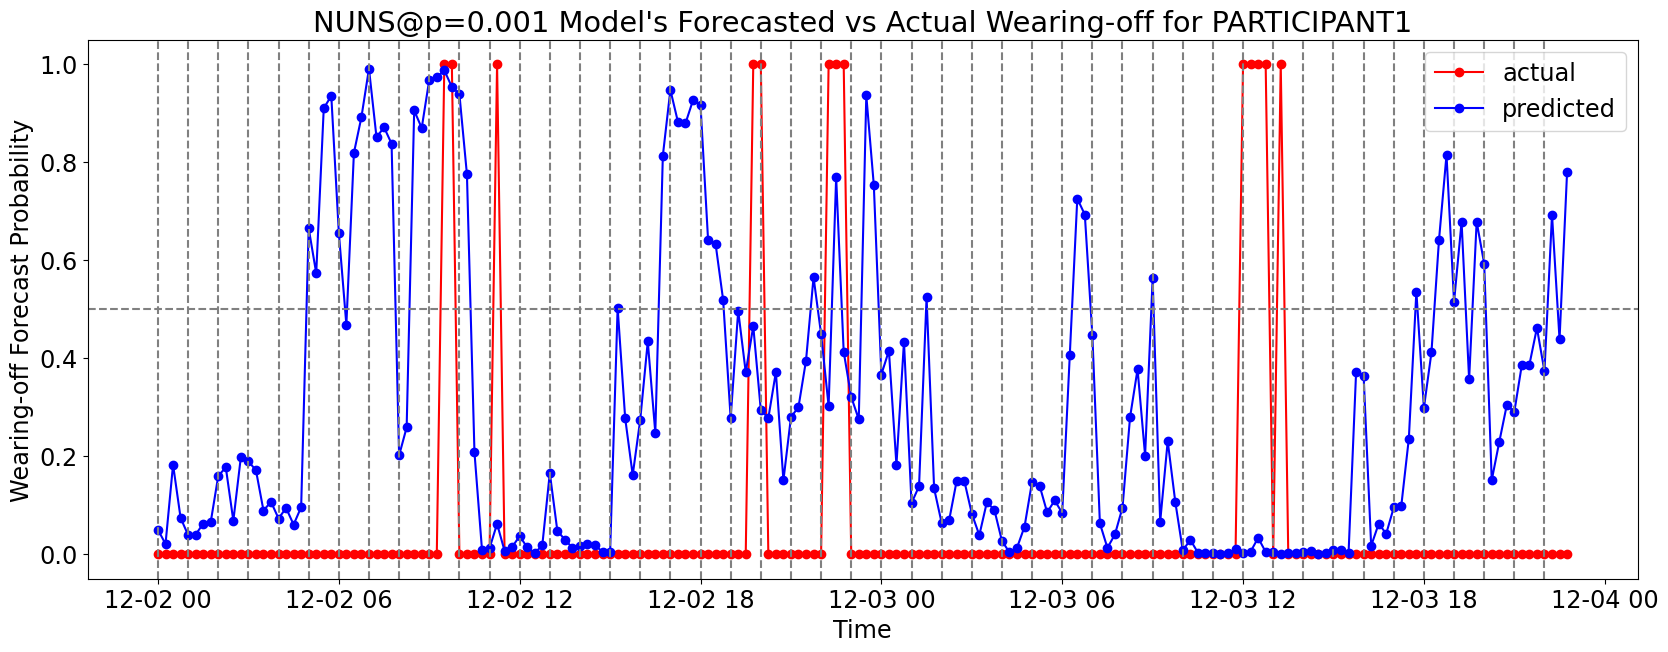

In [218]:
# Plot ground truth, and predicted probability on the same plot to show the difference
plt.figure(figsize=FIGSIZE)
plt.plot(forecasts_output.ground_truth,
         label='actual', color='red', marker='o',)
plt.plot(forecasts_output.forecasted_wearing_off_probability,
         label='predicted', color='blue', marker='o')
# plt.plot(forecasts_output.forecasted_wearing_off,
#          label='predicted', color='blue', marker='o')
plt.legend()

# Dashed horizontal line at 0.5
plt.axhline(0.5, linestyle='--', color='gray')

# Dashed vertical lines on each hour
for i in forecasts_output.index:
  if pd.Timestamp(i).minute == 0:
    plt.axvline(i, linestyle='--', color='gray')

# Set y-axis label
plt.ylabel('Wearing-off Forecast Probability')

# Set x-axis label
plt.xlabel('Time')

# Set title
plt.title(f"{model_name}'s Forecasted vs Actual Wearing-off for {USER.upper()}")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - actual vs forecast.png',
            bbox_inches='tight', dpi=500)

plt.show()

### Metric Scores

In [219]:
# evaluate predictions with f1 score, precision, recall, and accuracy
fpr, tpr, thresholds = metrics.roc_curve(forecasts_output.sort_index().ground_truth,
                                         forecasts_output.sort_index().forecasted_wearing_off_probability)

######################
model_metric_scores = pd.DataFrame(
  [
    metrics.f1_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.recall_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.precision_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.accuracy_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.auc(fpr, tpr),
    metrics.average_precision_score(
      forecasts_output.sort_index().ground_truth,
      forecasts_output.sort_index().forecasted_wearing_off_probability)
  ],
  index=['f1 score', 'recall', 'precision', 'accuracy', 'auc-roc', 'auc-prc'],
  columns=['metrics']
).T.round(3).assign(model=model_name, participant=USER)
model_metric_scores.set_index(['participant', 'model'], inplace=True)

######################
model_classification_report = pd.DataFrame(
  classification_report(
    forecasts_output.ground_truth,
    forecasts_output.forecasted_wearing_off,
    output_dict=True
  )
).T.round(3).assign(model=model_name, participant=USER)
# Set index's name to 'classification report'
model_classification_report.index.name = 'classification report'

# Remove row that has 'accuracy' as index
model_classification_report = model_classification_report.drop(
  ['accuracy'], axis=0)

model_classification_report = model_classification_report.reset_index()
model_classification_report.set_index(
    ['participant', 'model', 'classification report'], inplace=True)

model_metric_scores.reset_index(inplace=True)
model_classification_report.reset_index(inplace=True)

######################
# Recreate writer to open existing file
writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                        engine='openpyxl', mode='a', if_sheet_exists='overlay')

# Append data frame to Metric Scores sheet
model_metric_scores.to_excel(excel_writer=writer, sheet_name='Metric Scores',
                             startrow=writer.sheets['Metric Scores'].max_row,
                             header=False, index=False)
model_classification_report.to_excel(excel_writer=writer, sheet_name='Classification Report',
                                     startrow=writer.sheets['Classification Report'].max_row,
                                     header=False, index=False)
writer.close()

display(model_metric_scores)
display(model_classification_report)

,participant,model,f1 score,recall,precision,accuracy,auc-roc,auc-prc
0,participant1,NUNS@p=0.001 Model,0.102,0.231,0.065,0.718,0.48,0.134


,participant,model,classification report,precision,recall,f1-score,support
0,participant1,NUNS@p=0.001 Model,0.0,0.930,0.754,0.833,175.0
1,participant1,NUNS@p=0.001 Model,1.0,0.065,0.231,0.102,13.0
2,participant1,NUNS@p=0.001 Model,macro avg,0.497,0.493,0.467,188.0
3,participant1,NUNS@p=0.001 Model,weighted avg,0.870,0.718,0.782,188.0


### Confusion Matrix

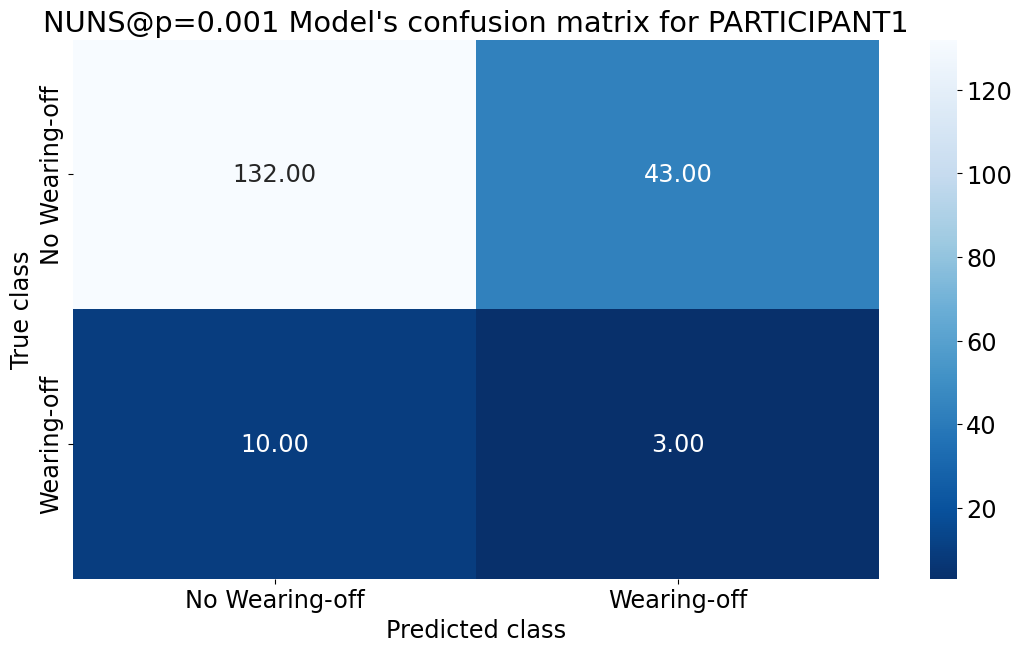

In [220]:
# Plot confusion matrix
labels = ['No Wearing-off', 'Wearing-off']
conf_matrix = confusion_matrix(forecasts_output.ground_truth,
                               forecasts_output.forecasted_wearing_off)
plt.figure(figsize=FIGSIZE_CM)
sns.heatmap(conf_matrix,
            xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='Blues_r')

# Set y-axis label
plt.ylabel('True class')

# Set x-axis label
plt.xlabel('Predicted class')

# Set title
plt.title(f"{model_name}'s confusion matrix for {USER.upper()}")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - confusion matrix.png',
            bbox_inches='tight', dpi=500)
plt.show()

######################
# Recreate writer to open existing file
writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                        engine='openpyxl', mode='a', if_sheet_exists='overlay')

# Append data frame to Metric Scores sheet
pd.DataFrame(
  data=[[USER, model_name] + list(conf_matrix.flatten())],
  columns=['participant', 'model', 'TN', 'FP', 'FN', 'TP']
).to_excel(excel_writer=writer, sheet_name='Confusion Matrix',
           startrow=writer.sheets['Confusion Matrix'].max_row,
           header=False, index=False)

writer.close()

### AU-ROC

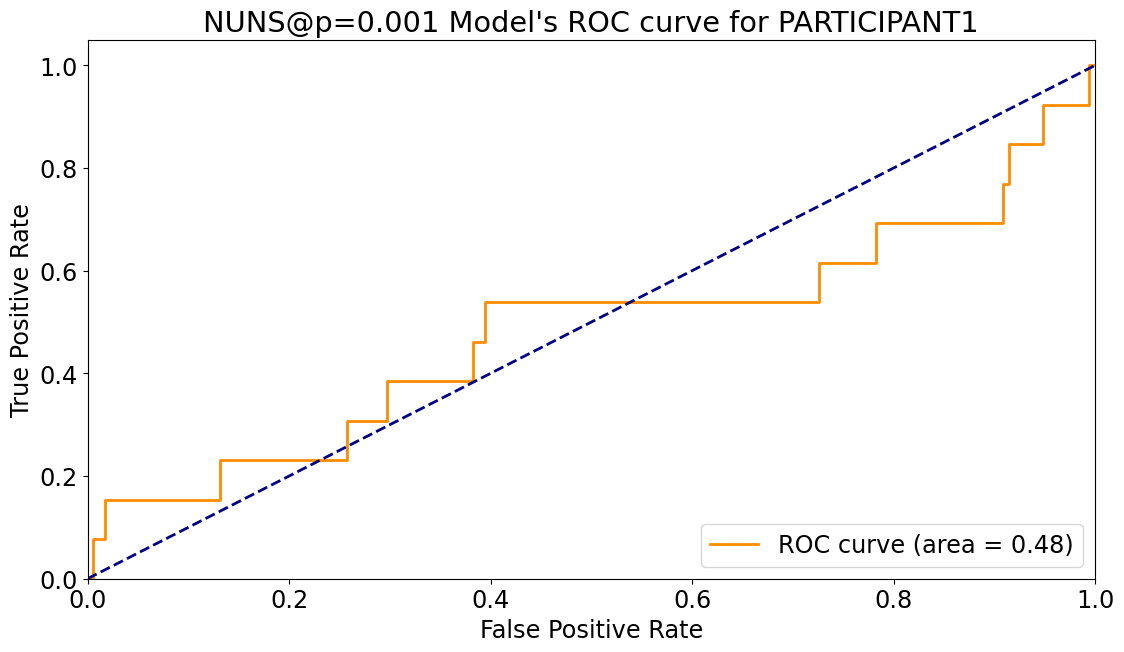

In [221]:
# Compute and graph ROC curve and AUC
fpr, tpr, thresholds = roc_curve(forecasts_output.sort_index().ground_truth,
                                 forecasts_output.sort_index().forecasted_wearing_off_probability)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=FIGSIZE_CM)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',
         lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set y-axis label
plt.ylabel('True Positive Rate')

# Set x-axis label
plt.xlabel('False Positive Rate')

# Set title
plt.title(f"{model_name}'s ROC curve for {USER.upper()}")

# Set legend
plt.legend(loc="lower right")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - ROC curve.png',
            bbox_inches='tight', dpi=500)

plt.show()

### AU-PRC

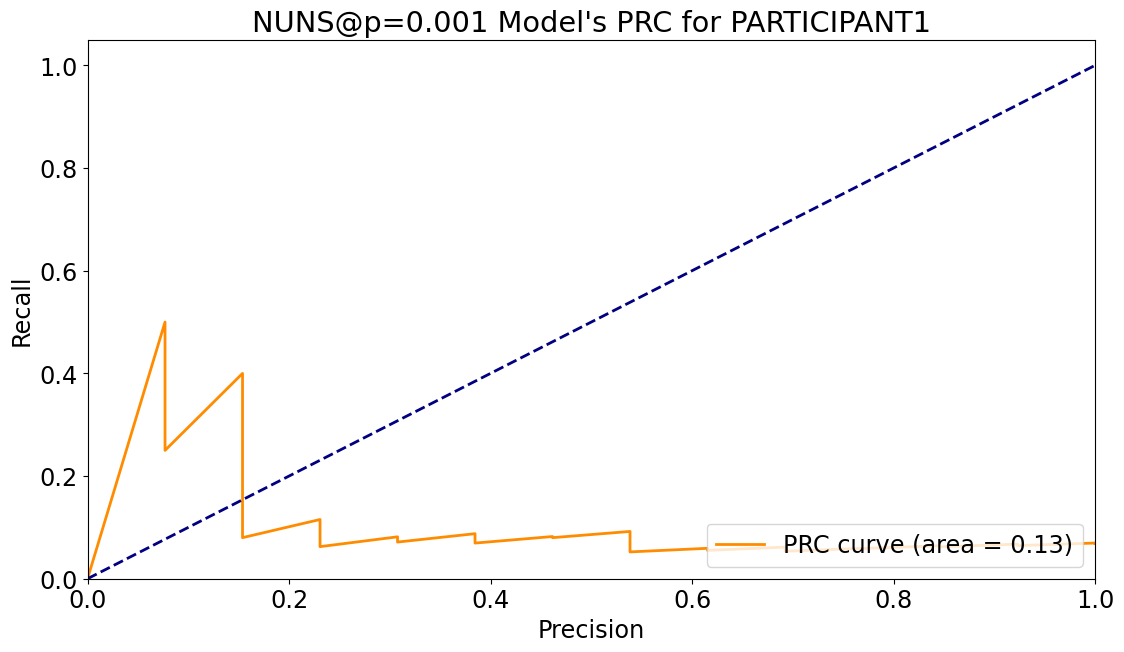

In [222]:
# Compute and graph PRC and AU-PRC
precision, recall, thresholds = precision_recall_curve(forecasts_output.sort_index().ground_truth,
                                                       forecasts_output.sort_index().forecasted_wearing_off_probability)
average_precision = average_precision_score(
  forecasts_output.sort_index().ground_truth,
  forecasts_output.sort_index().forecasted_wearing_off_probability)

plt.figure(figsize=FIGSIZE_CM)
plt.plot(recall, precision, color='darkorange',
         lw=2, label='PRC curve (area = %0.2f)' % average_precision)
plt.plot([0, 1], [0, 1], color='navy',
         lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set y-axis label
plt.ylabel('Recall')

# Set x-axis label
plt.xlabel('Precision')

# Set title
plt.title(f"{model_name}'s PRC for {USER.upper()}")

# Set legend
plt.legend(loc="lower right")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - PRC.png',
            bbox_inches='tight', dpi=500)

plt.show()

# NUNS+SMOTE Model
TODO:
* add SMOTE to NUNS
* problem with resampling probabilities since they take up the same shape as NUNS


In [ ]:
model_name = f'NUNS@p={sampling_rate} Model'

resampled_X, resampled_y, resampling_probabilities = non_uniform_negative_sampler(
    train_X, train_y, sampling_rate=sampling_rate)

# sm = SMOTE(random_state=4, k_neighbors=5)
# resampled_X, resampled_y = sm.fit_resample(resampled_X, resampled_y)

In [ ]:
# Combine these two into one dataframe
ratios = pd.DataFrame({
  'original_N0': train_y.value_counts()[0],
  'original_N1': train_y.value_counts()[1],
  'resampled_N0': resampled_y.value_counts()[0],
  'resampled_N1': resampled_y.value_counts()[1],
  'sampling_rate': sampling_rate,
}, index=[0]).assign(participant=USER, model=model_name)

ratios.set_index(['participant', 'model'], inplace=True)
ratios.reset_index(inplace=True)

# Recreate writer to open existing file
writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                        engine='openpyxl', mode='a', if_sheet_exists='overlay')

# Append data frame to Metric Scores sheet
ratios.to_excel(excel_writer=writer, sheet_name='Sampling Ratio',
                startrow=writer.sheets['Sampling Ratio'].max_row,
                header=False, index=False)
writer.close()

In [ ]:
from typing import Tuple
from scipy.special import expit as sigmoid


sample_weights = resampling_probabilities.values


def custom_logistic_obj(labels: np.ndarray, predt: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  '''
  Logistic loss objective function for binary-class classification
  '''
  y = labels
  p = sigmoid(predt + np.log(sample_weights))
  grad = p - y
  hess = p * (1.0 - p)
  return grad, hess


# Create XGBClassifier with custom objective function model instance
resampled_model = XGBClassifier(objective=custom_logistic_obj,
                                random_state=4, n_estimators=1000)
# fit model using resampled train data
resampled_model.fit(resampled_X, resampled_y)

# save XGBClassifier model
resampled_model.save_model(f'{RESULTS_PATH}/{USER}, {model_name}.json')

## Generate forecasts

In [ ]:
# Make forecasts
forecasts = resampled_model.predict(
  test_X
)

# Get the probability for 1s class
forecasts_proba = resampled_model.predict_proba(
  test_X
)[:, 1]

forecasts_output = pd.DataFrame(
  {
    'patient_id': [USER] * len(forecasts),
    'ground_truth': test_y.values.ravel(),
    'forecasted_wearing_off': forecasts,
    'forecasted_wearing_off_probability': forecasts_proba
  },
  columns=['patient_id', 'ground_truth',
           'forecasted_wearing_off',
           'forecasted_wearing_off_probability'],
  index=test_X.index
)
# forecasts_output

## Evaluation

### Actual vs Forecast

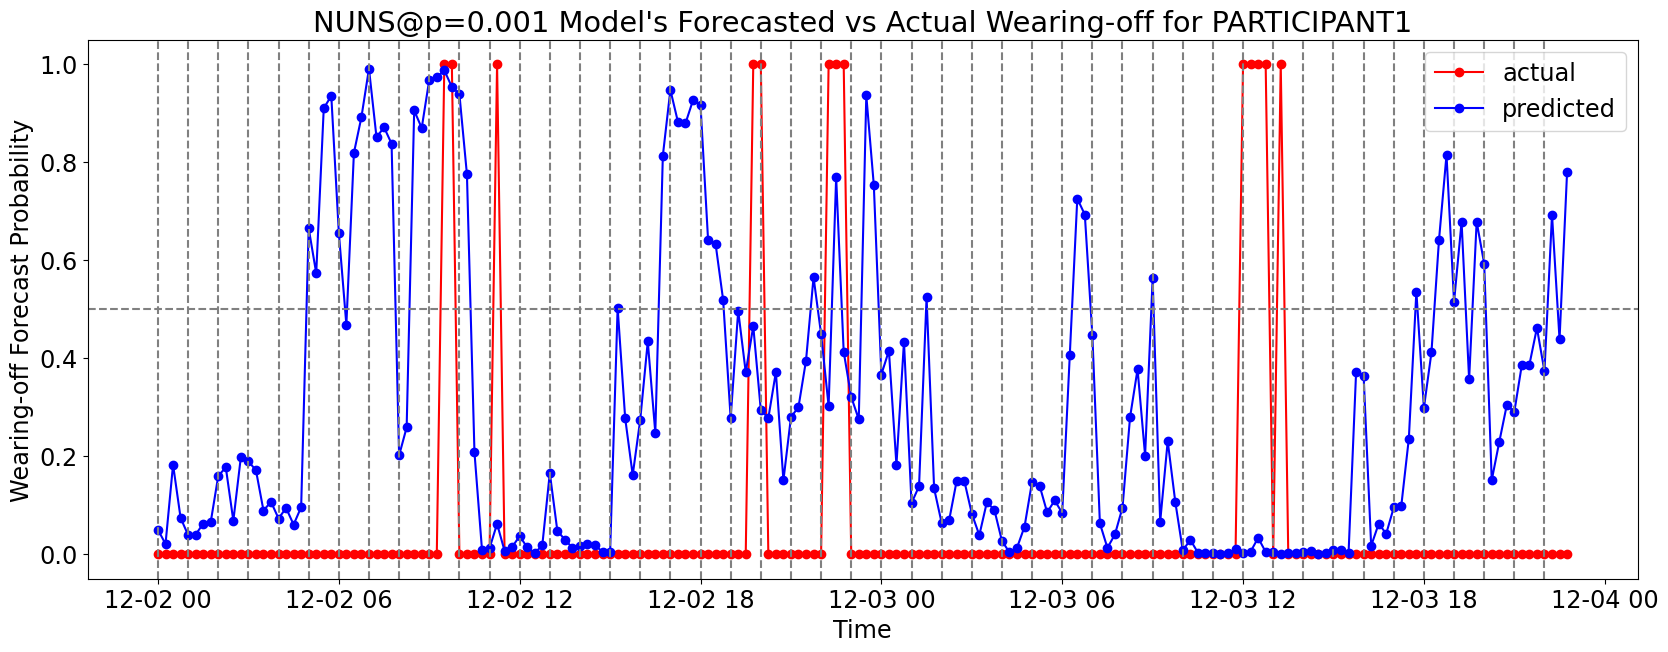

In [ ]:
# Plot ground truth, and predicted probability on the same plot to show the difference
plt.figure(figsize=FIGSIZE)
plt.plot(forecasts_output.ground_truth,
         label='actual', color='red', marker='o',)
plt.plot(forecasts_output.forecasted_wearing_off_probability,
         label='predicted', color='blue', marker='o')
# plt.plot(forecasts_output.forecasted_wearing_off,
#          label='predicted', color='blue', marker='o')
plt.legend()

# Dashed horizontal line at 0.5
plt.axhline(0.5, linestyle='--', color='gray')

# Dashed vertical lines on each hour
for i in forecasts_output.index:
  if pd.Timestamp(i).minute == 0:
    plt.axvline(i, linestyle='--', color='gray')

# Set y-axis label
plt.ylabel('Wearing-off Forecast Probability')

# Set x-axis label
plt.xlabel('Time')

# Set title
plt.title(f"{model_name}'s Forecasted vs Actual Wearing-off for {USER.upper()}")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - actual vs forecast.png',
            bbox_inches='tight', dpi=500)

plt.show()

### Metric Scores

In [ ]:
# evaluate predictions with f1 score, precision, recall, and accuracy
fpr, tpr, thresholds = metrics.roc_curve(forecasts_output.sort_index().ground_truth,
                                         forecasts_output.sort_index().forecasted_wearing_off_probability)

######################
model_metric_scores = pd.DataFrame(
  [
    metrics.f1_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.recall_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.precision_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.accuracy_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.auc(fpr, tpr),
    metrics.average_precision_score(
      forecasts_output.sort_index().ground_truth,
      forecasts_output.sort_index().forecasted_wearing_off_probability)
  ],
  index=['f1 score', 'recall', 'precision', 'accuracy', 'auc-roc', 'auc-prc'],
  columns=['metrics']
).T.round(3).assign(model=model_name, participant=USER)
model_metric_scores.set_index(['participant', 'model'], inplace=True)

######################
model_classification_report = pd.DataFrame(
  classification_report(
    forecasts_output.ground_truth,
    forecasts_output.forecasted_wearing_off,
    output_dict=True
  )
).T.round(3).assign(model=model_name, participant=USER)
# Set index's name to 'classification report'
model_classification_report.index.name = 'classification report'

# Remove row that has 'accuracy' as index
model_classification_report = model_classification_report.drop(
  ['accuracy'], axis=0)

model_classification_report = model_classification_report.reset_index()
model_classification_report.set_index(
    ['participant', 'model', 'classification report'], inplace=True)

model_metric_scores.reset_index(inplace=True)
model_classification_report.reset_index(inplace=True)

######################
# Recreate writer to open existing file
writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                        engine='openpyxl', mode='a', if_sheet_exists='overlay')

# Append data frame to Metric Scores sheet
model_metric_scores.to_excel(excel_writer=writer, sheet_name='Metric Scores',
                             startrow=writer.sheets['Metric Scores'].max_row,
                             header=False, index=False)
model_classification_report.to_excel(excel_writer=writer, sheet_name='Classification Report',
                                     startrow=writer.sheets['Classification Report'].max_row,
                                     header=False, index=False)
writer.close()

display(model_metric_scores)
display(model_classification_report)

,participant,model,f1 score,recall,precision,accuracy,auc-roc,auc-prc
0,participant1,NUNS@p=0.001 Model,0.102,0.231,0.065,0.718,0.48,0.134


,participant,model,classification report,precision,recall,f1-score,support
0,participant1,NUNS@p=0.001 Model,0.0,0.930,0.754,0.833,175.0
1,participant1,NUNS@p=0.001 Model,1.0,0.065,0.231,0.102,13.0
2,participant1,NUNS@p=0.001 Model,macro avg,0.497,0.493,0.467,188.0
3,participant1,NUNS@p=0.001 Model,weighted avg,0.870,0.718,0.782,188.0


### Confusion Matrix

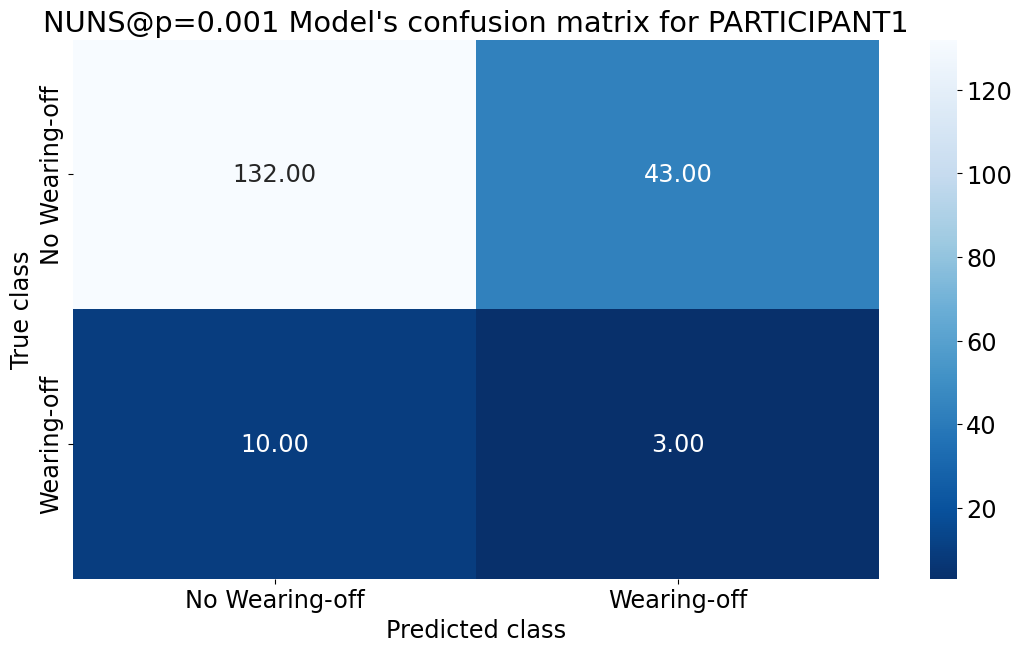

In [ ]:
# Plot confusion matrix
labels = ['No Wearing-off', 'Wearing-off']
conf_matrix = confusion_matrix(forecasts_output.ground_truth,
                               forecasts_output.forecasted_wearing_off)
plt.figure(figsize=FIGSIZE_CM)
sns.heatmap(conf_matrix,
            xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='Blues_r')

# Set y-axis label
plt.ylabel('True class')

# Set x-axis label
plt.xlabel('Predicted class')

# Set title
plt.title(f"{model_name}'s confusion matrix for {USER.upper()}")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - confusion matrix.png',
            bbox_inches='tight', dpi=500)
plt.show()

######################
# Recreate writer to open existing file
writer = pd.ExcelWriter(f'{RESULTS_PATH}/metric scores.xlsx',
                        engine='openpyxl', mode='a', if_sheet_exists='overlay')

# Append data frame to Metric Scores sheet
pd.DataFrame(
  data=[[USER, model_name] + list(conf_matrix.flatten())],
  columns=['participant', 'model', 'TN', 'FP', 'FN', 'TP']
).to_excel(excel_writer=writer, sheet_name='Confusion Matrix',
           startrow=writer.sheets['Confusion Matrix'].max_row,
           header=False, index=False)

writer.close()

### AU-ROC

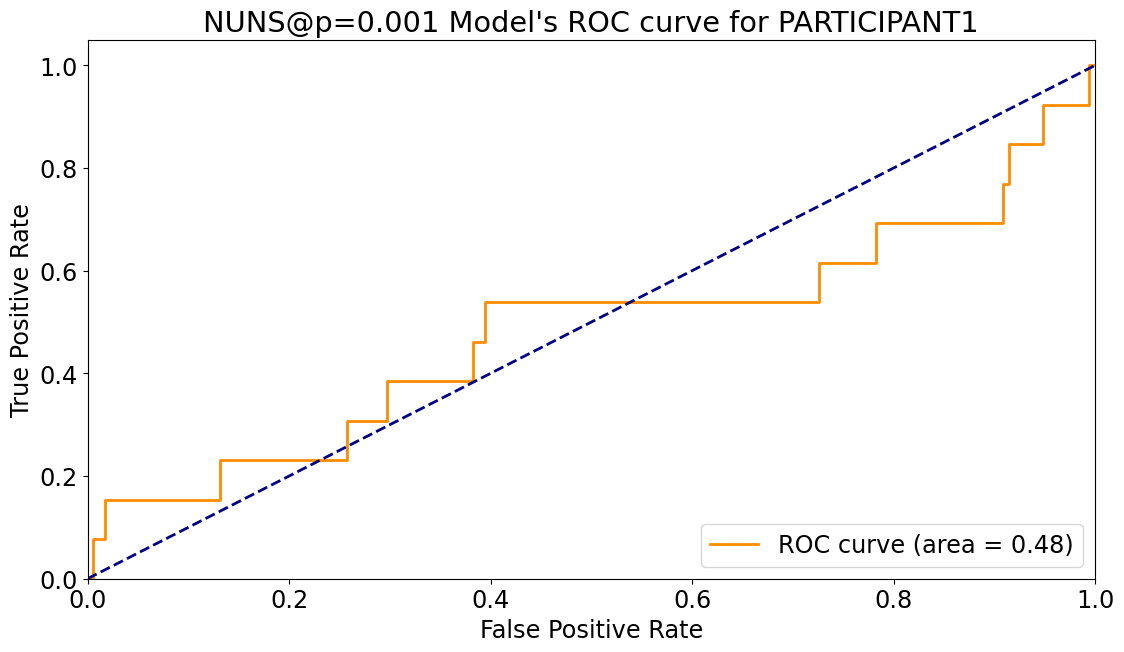

In [ ]:
# Compute and graph ROC curve and AUC
fpr, tpr, thresholds = roc_curve(forecasts_output.sort_index().ground_truth,
                                 forecasts_output.sort_index().forecasted_wearing_off_probability)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=FIGSIZE_CM)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',
         lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set y-axis label
plt.ylabel('True Positive Rate')

# Set x-axis label
plt.xlabel('False Positive Rate')

# Set title
plt.title(f"{model_name}'s ROC curve for {USER.upper()}")

# Set legend
plt.legend(loc="lower right")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - ROC curve.png',
            bbox_inches='tight', dpi=500)

plt.show()

### AU-PRC

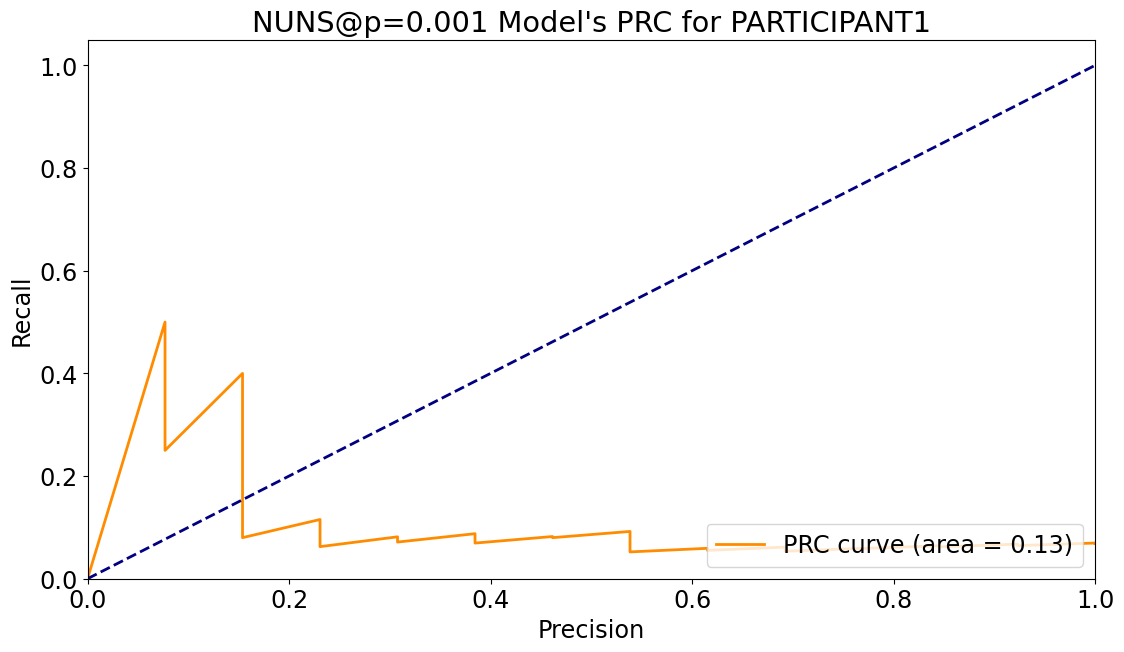

In [ ]:
# Compute and graph PRC and AU-PRC
precision, recall, thresholds = precision_recall_curve(forecasts_output.sort_index().ground_truth,
                                                       forecasts_output.sort_index().forecasted_wearing_off_probability)
average_precision = average_precision_score(
  forecasts_output.sort_index().ground_truth,
  forecasts_output.sort_index().forecasted_wearing_off_probability)

plt.figure(figsize=FIGSIZE_CM)
plt.plot(recall, precision, color='darkorange',
         lw=2, label='PRC curve (area = %0.2f)' % average_precision)
plt.plot([0, 1], [0, 1], color='navy',
         lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set y-axis label
plt.ylabel('Recall')

# Set x-axis label
plt.xlabel('Precision')

# Set title
plt.title(f"{model_name}'s PRC for {USER.upper()}")

# Set legend
plt.legend(loc="lower right")

# Save plot
plt.savefig(f'{RESULTS_PATH}/{USER}, {model_name} - PRC.png',
            bbox_inches='tight', dpi=500)

plt.show()